In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
import time


In [3]:
data = pd.read_csv('data/diabetes/diabetic_data.csv', na_values=['?', 'NULL', 'Not Available', 'Unknown/Invalid', 'Not Mapped'])

admission_type_mapping = pd.read_csv('data/diabetes/admission_type_id.csv')
admission_source_mapping = pd.read_csv('data/diabetes/admission_source_id.csv')
discharge_disposition_mapping = pd.read_csv('data/diabetes/discharge_disposition_id.csv')

/var/folders/rw/ng2fcx710pxgc1dgb03mqfpc0000gn/T/ipykernel_71879/3251502197.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/diabetes/diabetic_data.csv', na_values=['?', 'NULL', 'Not Available', 'Unknown/Invalid', 'Not Mapped'])


In [4]:
# Konvertieren Sie die IDs zu Strings, um spätere Probleme mit dem Datentyp zu vermeiden
admission_type_mapping['admission_type_id'] = admission_type_mapping['admission_type_id'].astype(str)
discharge_disposition_mapping['discharge_disposition_id'] = discharge_disposition_mapping['discharge_disposition_id'].astype(str)
admission_source_mapping['admission_source_id'] = admission_source_mapping['admission_source_id'].astype(str)

In [5]:
# Konvertieren Sie auch die entsprechenden Spalten im Hauptdatensatz zu Strings
data['admission_type_id'] = data['admission_type_id'].astype(str)
discharge_disposition_mapping['discharge_disposition_id'] = discharge_disposition_mapping['discharge_disposition_id'].astype(str)
admission_source_mapping['admission_source_id'] = admission_source_mapping['admission_source_id'].astype(str)


In [6]:
data['admission_type_id'] = data['admission_type_id'].astype(str)
data['discharge_disposition_id'] = data['discharge_disposition_id'].astype(str)
data['admission_source_id'] = data['admission_source_id'].astype(str)


In [7]:
data = data.merge(admission_type_mapping, how='left', left_on='admission_type_id', right_on='admission_type_id', suffixes=('', '_admission'))
data = data.merge(discharge_disposition_mapping, how='left', left_on='discharge_disposition_id', right_on='discharge_disposition_id', suffixes=('', '_discharge'))
data = data.merge(admission_source_mapping, how='left', left_on='admission_source_id', right_on='admission_source_id', suffixes=('', '_source'))


In [8]:
data.rename(columns={
    'description': 'admission_type',
    'description_discharge': 'discharge_disposition',
    'description_source': 'admission_source'
}, inplace=True)
data.drop(columns=['admission_type_id', 'discharge_disposition_id', 'admission_source_id'], inplace=True)


In [9]:
num_rows, num_cols = data.shape
print(f'Data shape: {num_rows} rows, {num_cols} columns')

Data shape: 101766 rows, 50 columns


weight                      96.858479
max_glu_serum               94.746772
A1Cresult                   83.277322
medical_specialty           49.082208
payer_code                  39.557416
admission_source             6.663326
admission_type               5.199182
discharge_disposition        3.626948
race                         2.233555
diag_3                       1.398306
diag_2                       0.351787
diag_1                       0.020636
gender                       0.002948
metformin-pioglitazone       0.000000
insulin                      0.000000
acarbose                     0.000000
miglitol                     0.000000
troglitazone                 0.000000
tolazamide                   0.000000
examide                      0.000000
citoglipton                  0.000000
glyburide-metformin          0.000000
metformin-rosiglitazone      0.000000
readmitted                   0.000000
glipizide-metformin          0.000000
diabetesMed                  0.000000
change      

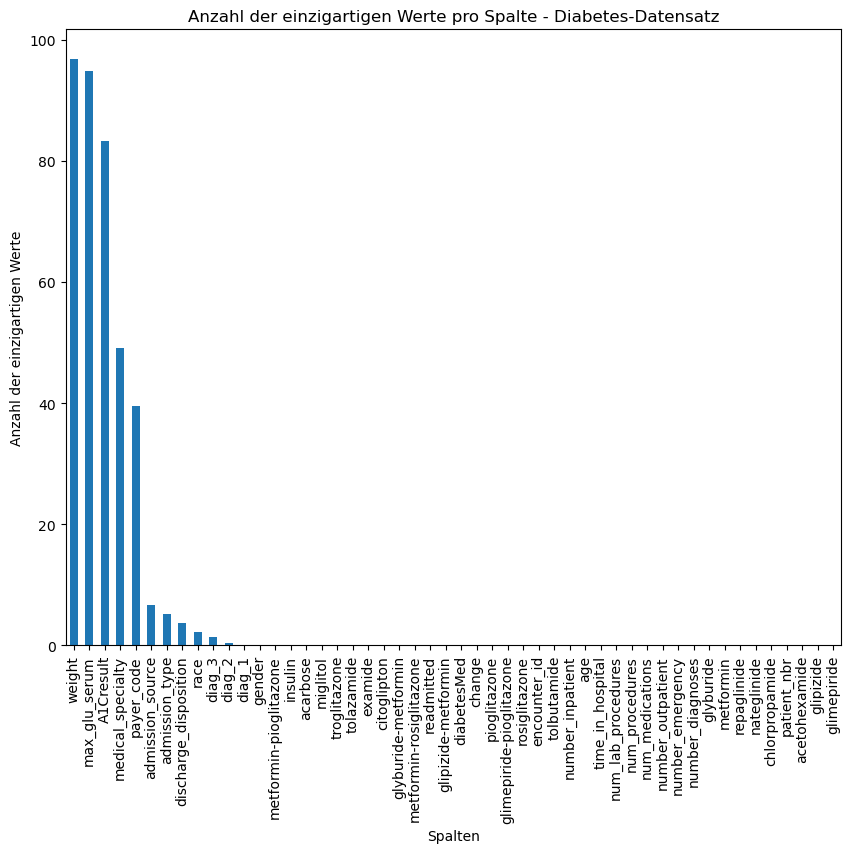

In [10]:
missing_values = data.isnull().mean() * 100
missing_values_sorted = missing_values.sort_values(ascending=False)
print(missing_values_sorted)

# Visualisierung der fehlenden Werte
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_values.index, y=missing_values)
plt.xticks(rotation=90)
plt.title('Prozentualer Anteil fehlender Werte pro Spalte')
plt.ylabel('Fehlende Werte (%)')
plt.show()


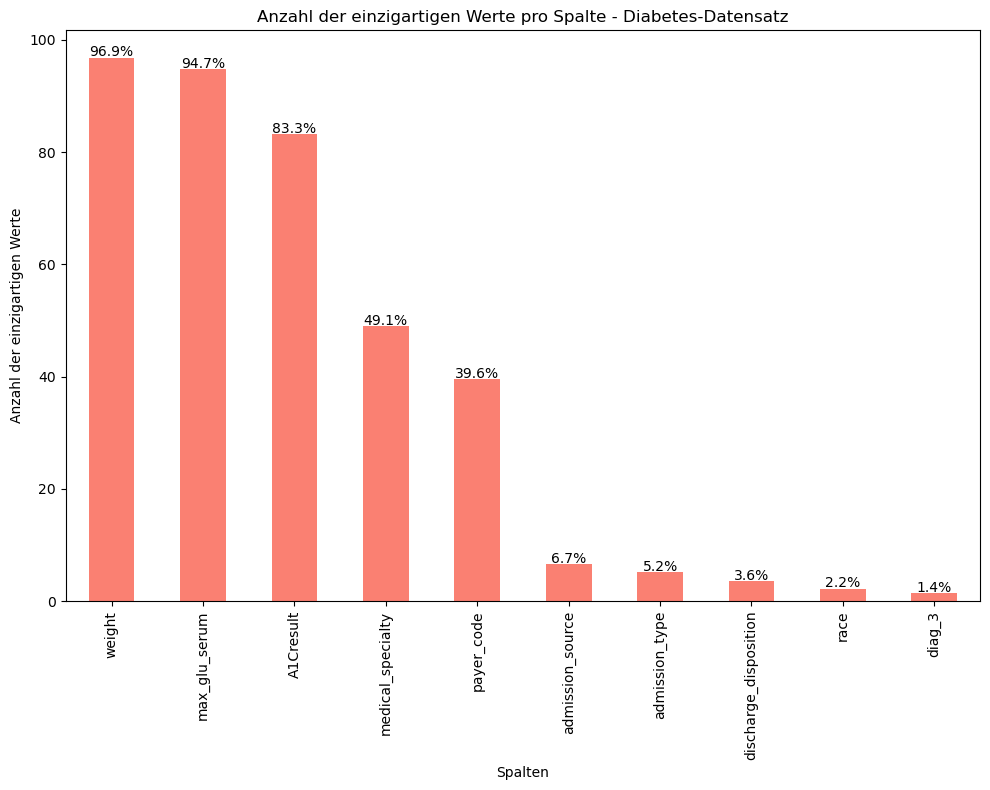

In [16]:
# Anzahl der eindeutigen Werte pro Spalte
unique_values_per_column = missing_values_sorted.nunique()
unique_values_sorted = missing_values_sorted.sort_values(ascending=False)
unique_values_sorted = unique_values_sorted[unique_values_sorted > 1]  # Filtern nur eindeutige Werte

# Graph für eindeutige Werte
plt.figure(figsize=(10, 8))
ax = unique_values_sorted.plot(kind='bar', color='salmon')
plt.title('Anzahl der einzigartigen Werte pro Spalte - Diabetes-Datensatz')
plt.xlabel('Spalten')
plt.ylabel('Anzahl der einzigartigen Werte')
plt.xticks(rotation=90)
plt.tight_layout()

# Prozentzahlen auf den Balken anzeigen
for i, v in enumerate(unique_values_sorted):
    ax.text(i, v + 0.2, f'{v:.1f}%', ha='center')


plt.savefig('unique_values_diabetes.svg', format='svg')
plt.show()


In [67]:
missing_values_before = data[['medical_specialty', 'payer_code', 'admission_type', 'admission_source', 'discharge_disposition']].isna().sum()
print("Fehlende Werte in den relevanten Spalten vor dem One-Hot-Encoding:")
print(missing_values_before)

Fehlende Werte in den relevanten Spalten vor dem One-Hot-Encoding:
medical_specialty        49949
payer_code               40256
admission_type            5291
admission_source          6781
discharge_disposition     3691
dtype: int64


In [68]:
data_cleaned = data.drop(columns=['weight', 'max_glu_serum', 'A1Cresult'])
# Fehlende Werte vor dem One-Hot-Encoding markieren
for col in data_cleaned.columns:
    if data_cleaned[col].isnull().any():
        data_cleaned[col + '_nan'] = data_cleaned[col].isnull()

Moderate Anzahl fehlender Werte: Diese Spalten haben genug fehlende Werte, um eine sinnvolle Evaluation zu ermöglichen, aber nicht so viele, dass die Imputation extrem schwierig wird.

medical_specialty (49.08% fehlend)
payer_code (39.56% fehlend)
admission_type (10.22% fehlend)
admission_source (6.66% fehlend)
discharge_disposition (4.60% fehlend)

In [69]:
# Fehlende Werte vor dem One-Hot-Encoding markieren
for col in data_cleaned.columns:
    if data_cleaned[col].isnull().any():
        data_cleaned[col + '_nan'] = data_cleaned[col].isnull()

In [70]:
# Kategorische Spalten mit vielen eindeutigen Werten für Label-Encoding
label_encode_columns = ['diag_1', 'diag_2', 'diag_3']

# Label-Encoding anwenden
label_encoder = LabelEncoder()
for col in label_encode_columns:
    data_cleaned[col] = label_encoder.fit_transform(data_cleaned[col].astype(str))

print(data_cleaned[['diag_1', 'diag_2', 'diag_3']].head())



   diag_1  diag_2  diag_3
0     124     748     789
1     143      79     121
2     454      78     766
3     554      97     248
4      54      24      86


In [71]:
# Kategorische Spalten mit wenigen eindeutigen Werten für One-Hot-Encoding
one_hot_encode_columns = ['race', 'gender', 'age', 'change', 'diabetesMed', 'metformin', 'repaglinide', 'nateglinide', 
                          'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 
                          'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 
                          'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
                          'metformin-rosiglitazone', 'metformin-pioglitazone']

# One-Hot-Encoding anwenden
data_encoded = pd.get_dummies(data_cleaned, columns=one_hot_encode_columns, drop_first=True)

# Überblick über den kodierten Datensatz
print(data_encoded.head())
print(data_encoded.columns)

# Überprüfen der fehlenden Werte nach dem One-Hot-Encoding
missing_values_after = data_encoded.isna().sum()
print("Fehlende Werte nach dem One-Hot-Encoding:")
print(missing_values_after)

   encounter_id  patient_nbr  time_in_hospital payer_code  \
0       2278392      8222157                 1        NaN   
1        149190     55629189                 3        NaN   
2         64410     86047875                 2        NaN   
3        500364     82442376                 2        NaN   
4         16680     42519267                 1        NaN   

          medical_specialty  num_lab_procedures  num_procedures  \
0  Pediatrics-Endocrinology                  41               0   
1                       NaN                  59               0   
2                       NaN                  11               5   
3                       NaN                  44               1   
4                       NaN                  51               0   

   num_medications  number_outpatient  number_emergency  ...  insulin_No  \
0                1                  0                 0  ...        True   
1               18                  0                 0  ...       False   
2 

In [72]:
# Relevante Spalten für die Imputation
impute_columns = ['medical_specialty', 'payer_code', 'admission_type', 'admission_source', 'discharge_disposition']

# Kopieren der relevanten Spalten vor der Imputation
data_to_impute = data_cleaned[impute_columns]

# Anzahl fehlender Werte vor der Imputation überprüfen
missing_values_before_imputation = data_to_impute.isna().sum()
print("Fehlende Werte vor der Imputation:")
print(missing_values_before_imputation)

Fehlende Werte vor der Imputation:
medical_specialty        49949
payer_code               40256
admission_type            5291
admission_source          6781
discharge_disposition     3691
dtype: int64


In [73]:
# Aufteilung des Datensatzes in Trainings- und Testdatensätze
train_data, test_data = train_test_split(data_encoded, test_size=0.2, random_state=42)

print(train_data.shape)
print(test_data.shape)

(81412, 93)
(20354, 93)


In [74]:
# KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Laufzeit messen
start_time = time.time()

# Imputation durchführen
data_imputed = pd.DataFrame(knn_imputer.fit_transform(data_to_impute), columns=impute_columns)

end_time = time.time()
knn_runtime = end_time - start_time

# Anzahl fehlender Werte vor und nach der Imputation
missing_before = data_to_impute.isna().sum()
missing_after = data_imputed.isna().sum()

# Überblick über die Anzahl fehlender Werte vor und nach der Imputation
print("Fehlende Werte vor der Imputation:")
print(missing_before)
print("Fehlende Werte nach der Imputation:")
print(missing_after)

# Anzahl der gefüllten Felder
filled_values = missing_before - missing_after
print("Anzahl der gefüllten Felder:")
print(filled_values)

# Laufzeit anzeigen
print(f'KNN Imputer - Laufzeit: {knn_runtime} Sekunden')

ValueError: could not convert string to float: 'Pediatrics-Endocrinology'

In [ ]:
# Beispiel für die Berechnung der MSE, wenn echte Werte vorhanden wären
def calculate_mse(original_data, imputed_data, feature):
    """
    Berechnet die Mean Squared Error (MSE) für eine bestimmte Spalte.

    Parameters:
    original_data (pandas.DataFrame): Originale Daten mit fehlenden Werten
    imputed_data (pandas.DataFrame): Daten nach der Imputation
    feature (str): Spaltenname der zu berechnenden Spalte

    Returns:
    float: Mean Squared Error (MSE)
    """
    original_feature = original_data[feature]
    imputed_feature = imputed_data[feature]

    # Nur die fehlenden Werte im Originaldatensatz berücksichtigen
    mask = original_feature.isna()